In [61]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO

# dots
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

# lamp1
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball  
import warnings
warnings.filterwarnings('ignore')

#shell
from aicssegmentation.core.utils import get_middle_frame, hole_filling, get_3dseed_from_mid_frame
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d

from skimage import filters as skfilters
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from skimage import filters as skfilters

In [132]:
filename = r"\\allen\aics\assay-dev\users\Sandi\aics-segmentation\lookup_table_demo\pcna\deconvolution\raw\PCNA-decon-sc100-p100-e10-v9.ome.tif"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Attempted file (//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/pcna/deconvolution/raw/PCNA-decon-sc100-p100-e10-v9.ome.tif) load with reader: aicsimageio.readers.bfio_reader.OmeTiledTiffReader failed with error: No module named 'bfio'
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(1, 4, 75, 624, 924)


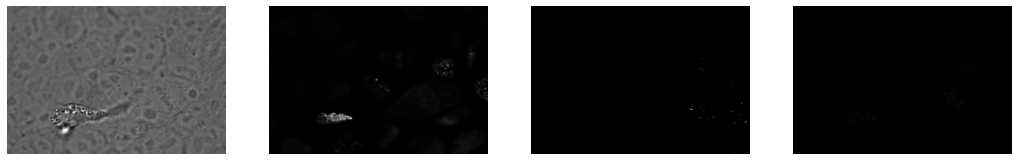

In [133]:
N_CHANNELS = IMG.shape[1] # N_CHANNELS = IMG.shape[1] 
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [134]:
#####################
structure_channel = 1

#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()

view(single_fluorescent_view(struct_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [135]:
#### PRE-PROCESSING ####

# Intensity scaling and smoothing
intensity_scaling_param = [0.5, 18]
gaussian_smoothing_sigma = 1

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

In [136]:
#### CORE ALGORITHM ####

# Otsu thresholding
# increase th, thinner/less segmentation. decrease th, chunkier/more segmentation.
th = 7.60* threshold_otsu(structure_img_smooth) # original at 1.4 # current: 3.90
overall_shape = dilation(
    remove_small_objects(structure_img_smooth > th, min_size=1, connectivity=1, in_place=False), #min_size = 10
    ball(1)
)
fixed_shape = erosion(
    hole_filling(overall_shape, hole_min=0, hole_max=5, fill_2d=True), #, hole_min= 0 hole_max = 5
    ball(1)
)


# 2D Spot Filter
# s2_param = [[3, 0.01]]
# bw = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

In [137]:
# # Mask Object Thresholding
# bw1, object_for_debug = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True, 
#                           local_adjust=1.95)

In [138]:
#### POST-PROCESSING ####

minArea = 50
seg = remove_small_objects(fixed_shape>0, min_size=minArea, connectivity=1, in_place=False)

In [139]:
# save file

out=seg.astype(np.uint8)
out[out>0]=255

imsave("pcna-deconseg-sc100-p100-e10v9.tiff", out) 